# 3. 가설 검정 (Hypothesis Testing)

## 목표
1. H1: 장타형 타자가 안타형 타자보다 타율 변동성(CV)이 크다
2. H2: 포지션에 따라 타격 일관성에 차이가 있다
3. H3: 경력이 쌓일수록 성적 안정성이 높아진다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu, kruskal, ranksums
import warnings
warnings.filterwarnings('ignore')

nanum_candidates = [
    '/Users/hoyana/Library/Fonts/NanumGothic-Regular.ttf',
    '/Users/hoyana/Library/Fonts/NanumGothic-Bold.ttf',
    '/Users/hoyana/Library/Fonts/NanumGothic-ExtraBold.ttf',
    '/Library/Fonts/NanumGothic-Regular.ttf',
    '/Library/Fonts/NanumGothic-Bold.ttf',
    '/Library/Fonts/NanumGothic-ExtraBold.ttf',
]
for path in nanum_candidates:
    if Path(path).exists():
        fm.fontManager.addfont(path)

plt.rcParams['font.family'] = ['NanumGothic', 'AppleGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


## 3.1 데이터 로드

In [2]:
data_path = '../outputs/'
df = pd.read_csv(data_path + 'eda_data.csv')

print(f"데이터 Shape: {df.shape}")
df.head()

데이터 Shape: (903, 43)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,age,position_group,career_years,career_group,HR_per_AB,batter_type,CV,std_daily_avg,games_count,consistency_level
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,34.0,내야수,1,5년차 이하,0.043716,장타형,0.892193,0.280743,50,안정
1,1,강경학,2015,한화,0.257,120,311,50,80,7,...,24.0,내야수,8,6년차 이상,0.006431,안타형,1.175115,0.272672,103,불안정
2,1,강경학,2016,한화,0.158,46,101,16,16,3,...,25.0,내야수,8,6년차 이상,0.009901,안타형,1.426298,0.194028,37,매우 불안정
3,1,강경학,2018,한화,0.278,77,245,42,68,11,...,27.0,내야수,8,6년차 이상,0.020408,안타형,1.056978,0.271967,73,불안정
4,4,강민호,2005,롯데,0.243,104,214,20,52,11,...,21.0,포수,15,6년차 이상,0.009346,안타형,1.378389,0.288523,93,매우 불안정


## 3.2 가설 1: 장타형 타자가 안타형 타자보다 타율 변동성(CV)이 크다

### 귀무가설 (H0): 장타형과 안타형 타자의 CV 차이가 없다
### 대립가설 (H1): 장타형 타자의 CV가 안타형보다 크다

In [3]:
power_hitters = df[df['batter_type'] == '장타형']['CV'].dropna()
contact_hitters = df[df['batter_type'] == '안타형']['CV'].dropna()

print("=== 기술 통계량 ===")
print(f"\n장타형 타자 (n={len(power_hitters)}):")
print(f"  평균 CV: {power_hitters.mean():.4f}")
print(f"  표준편차: {power_hitters.std():.4f}")
print(f"  중앙값: {power_hitters.median():.4f}")

print(f"\n안타형 타자 (n={len(contact_hitters)}):")
print(f"  평균 CV: {contact_hitters.mean():.4f}")
print(f"  표준편차: {contact_hitters.std():.4f}")
print(f"  중앙값: {contact_hitters.median():.4f}")

print(f"\n평균 차이: {power_hitters.mean() - contact_hitters.mean():.4f}")

=== 기술 통계량 ===

장타형 타자 (n=389):
  평균 CV: 0.9867
  표준편차: 0.2022
  중앙값: 0.9392

안타형 타자 (n=514):
  평균 CV: 1.1098
  표준편차: 0.2334
  중앙값: 1.0809

평균 차이: -0.1231


In [4]:
stat_power, p_power = shapiro(power_hitters)
stat_contact, p_contact = shapiro(contact_hitters)

print("\n=== 정규성 검정 (Shapiro-Wilk Test) ===")
print(f"장타형: statistic={stat_power:.4f}, p-value={p_power:.4f}")
print(f"안타형: statistic={stat_contact:.4f}, p-value={p_contact:.4f}")

if p_power < 0.05 or p_contact < 0.05:
    print("\n결론: 정규분포를 따르지 않음 → 비모수 검정 사용")
    normality = False
else:
    print("\n결론: 정규분포를 따름 → 모수 검정 사용 가능")
    normality = True


=== 정규성 검정 (Shapiro-Wilk Test) ===
장타형: statistic=0.9291, p-value=0.0000
안타형: statistic=0.9731, p-value=0.0000

결론: 정규분포를 따르지 않음 → 비모수 검정 사용


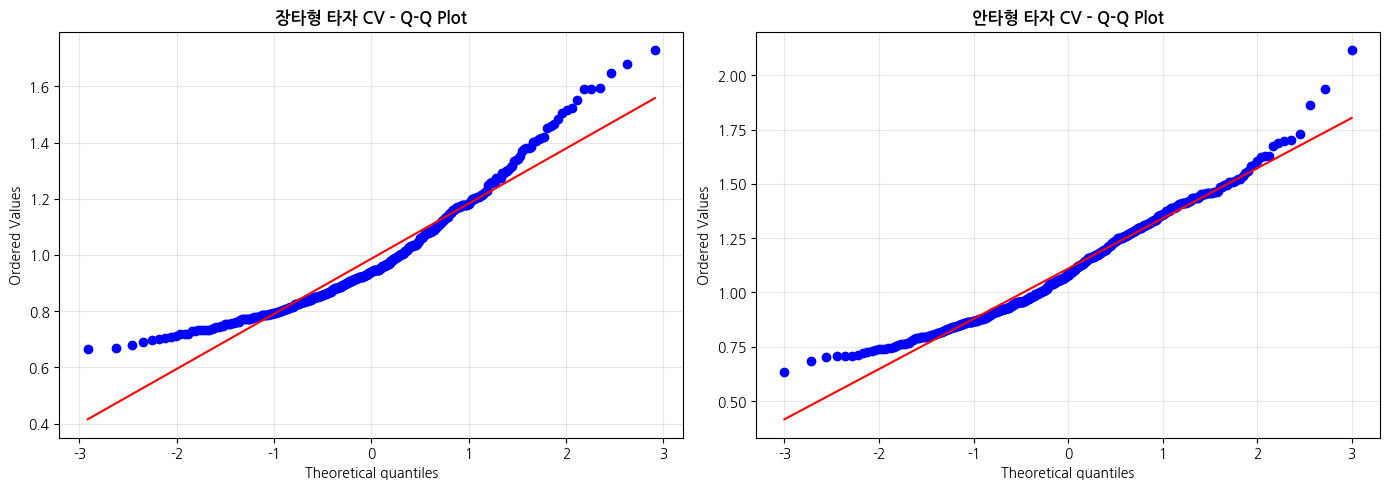

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stats.probplot(power_hitters, dist="norm", plot=axes[0])
axes[0].set_title('장타형 타자 CV - Q-Q Plot', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

stats.probplot(contact_hitters, dist="norm", plot=axes[1])
axes[1].set_title('안타형 타자 CV - Q-Q Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_path + 'h1_qqplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
if not normality:
    stat, p_value = ranksums(power_hitters, contact_hitters, alternative='greater')
    test_name = "Wilcoxon Rank-Sum Test (단측)"
else:
    stat, p_value = stats.ttest_ind(power_hitters, contact_hitters, alternative='greater')
    test_name = "Independent T-Test (단측)"

print(f"\n=== {test_name} ===")
print(f"검정 통계량: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\n결론: p-value({p_value:.4f}) < α({alpha})")
    print("귀무가설 기각 → 장타형 타자의 CV가 안타형보다 유의미하게 크다")
else:
    print(f"\n결론: p-value({p_value:.4f}) >= α({alpha})")
    print("귀무가설 유지 → 장타형과 안타형 타자의 CV 차이가 유의미하지 않다")


=== Wilcoxon Rank-Sum Test (단측) ===
검정 통계량: -8.3186
p-value: 1.0000

결론: p-value(1.0000) >= α(0.05)
귀무가설 유지 → 장타형과 안타형 타자의 CV 차이가 유의미하지 않다


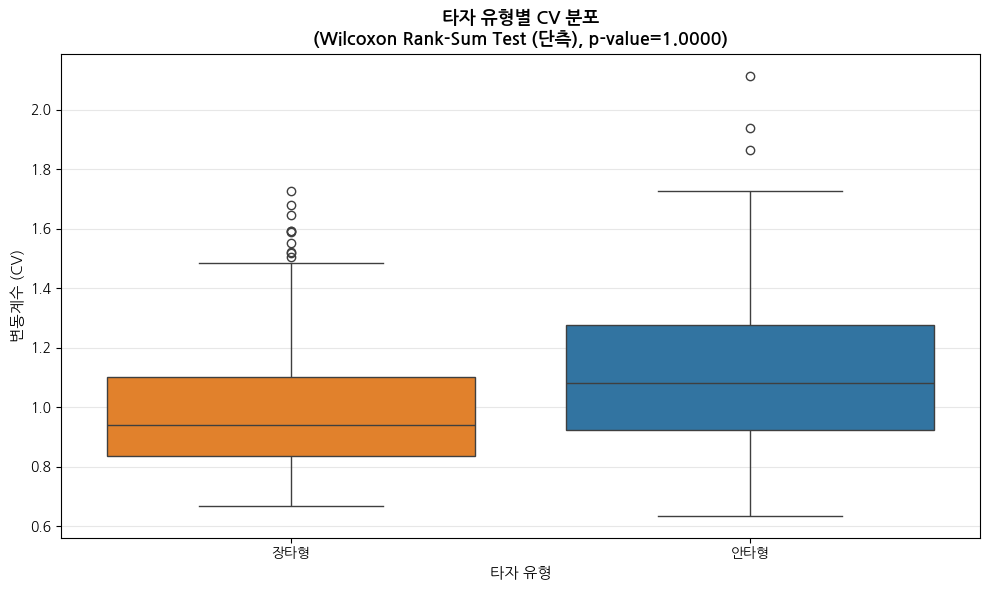

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='batter_type', y='CV', palette=['#ff7f0e', '#1f77b4'])
plt.title(f'타자 유형별 CV 분포\n({test_name}, p-value={p_value:.4f})', 
          fontsize=13, fontweight='bold')
plt.xlabel('타자 유형', fontsize=11)
plt.ylabel('변동계수 (CV)', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(data_path + 'h1_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.3 가설 2: 포지션에 따라 타격 일관성에 차이가 있다

### 귀무가설 (H0): 포지션별 CV에 차이가 없다
### 대립가설 (H1): 포지션별 CV에 차이가 있다

In [8]:
position_data = df[df['position_group'].isin(['내야수', '외야수', '포수'])].copy()

infielder = position_data[position_data['position_group'] == '내야수']['CV'].dropna()
outfielder = position_data[position_data['position_group'] == '외야수']['CV'].dropna()
catcher = position_data[position_data['position_group'] == '포수']['CV'].dropna()

print("=== 포지션별 기술 통계량 ===")
print(f"\n내야수 (n={len(infielder)}):")
print(f"  평균 CV: {infielder.mean():.4f}, 표준편차: {infielder.std():.4f}")

print(f"\n외야수 (n={len(outfielder)}):")
print(f"  평균 CV: {outfielder.mean():.4f}, 표준편차: {outfielder.std():.4f}")

print(f"\n포수 (n={len(catcher)}):")
print(f"  평균 CV: {catcher.mean():.4f}, 표준편차: {catcher.std():.4f}")

=== 포지션별 기술 통계량 ===

내야수 (n=467):
  평균 CV: 1.0648, 표준편차: 0.2250

외야수 (n=346):
  평균 CV: 1.0086, 표준편차: 0.2138

포수 (n=90):
  평균 CV: 1.2004, 표준편차: 0.2397


In [9]:
stat_in, p_in = shapiro(infielder)
stat_out, p_out = shapiro(outfielder)
stat_cat, p_cat = shapiro(catcher)

print("\n=== 정규성 검정 (Shapiro-Wilk Test) ===")
print(f"내야수: p-value={p_in:.4f}")
print(f"외야수: p-value={p_out:.4f}")
print(f"포수: p-value={p_cat:.4f}")

if p_in < 0.05 or p_out < 0.05 or p_cat < 0.05:
    print("\n결론: 정규분포를 따르지 않음 → Kruskal-Wallis Test 사용")
    normality_pos = False
else:
    print("\n결론: 정규분포를 따름 → ANOVA 사용 가능")
    normality_pos = True


=== 정규성 검정 (Shapiro-Wilk Test) ===
내야수: p-value=0.0000
외야수: p-value=0.0000
포수: p-value=0.0012

결론: 정규분포를 따르지 않음 → Kruskal-Wallis Test 사용


In [10]:
if not normality_pos:
    stat, p_value = kruskal(infielder, outfielder, catcher)
    test_name = "Kruskal-Wallis Test"
else:
    stat, p_value = stats.f_oneway(infielder, outfielder, catcher)
    test_name = "One-way ANOVA"

print(f"\n=== {test_name} ===")
print(f"검정 통계량: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\n결론: p-value({p_value:.4f}) < α({alpha})")
    print("귀무가설 기각 → 포지션별 CV에 유의미한 차이가 있다")
else:
    print(f"\n결론: p-value({p_value:.4f}) >= α({alpha})")
    print("귀무가설 유지 → 포지션별 CV에 유의미한 차이가 없다")


=== Kruskal-Wallis Test ===
검정 통계량: 49.3163
p-value: 0.0000

결론: p-value(0.0000) < α(0.05)
귀무가설 기각 → 포지션별 CV에 유의미한 차이가 있다


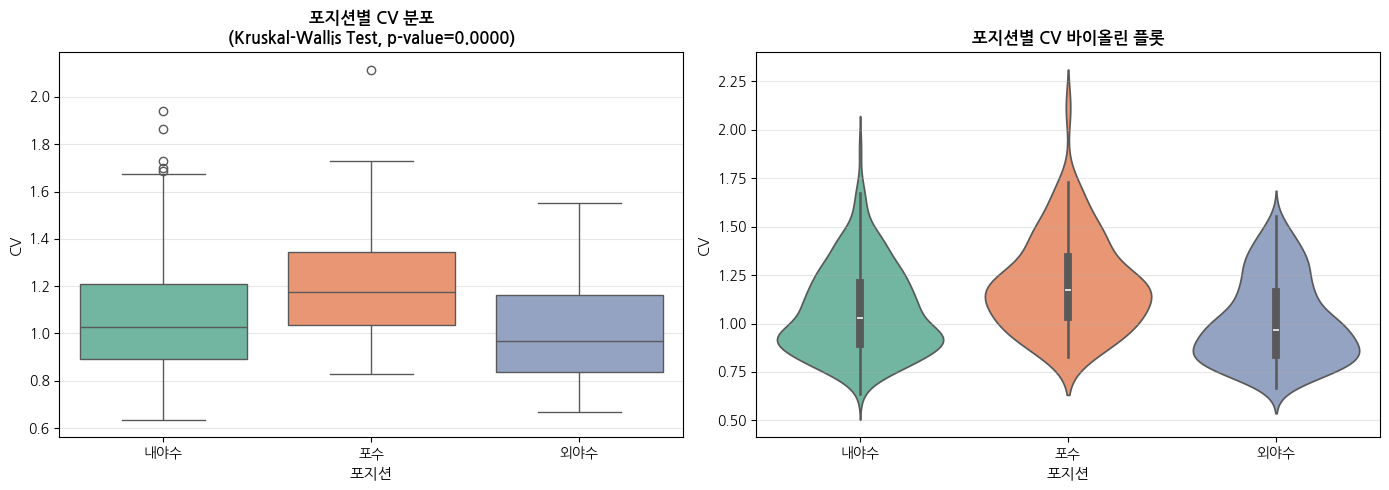

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=position_data, x='position_group', y='CV', ax=axes[0], palette='Set2')
axes[0].set_title(f'포지션별 CV 분포\n({test_name}, p-value={p_value:.4f})', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('포지션', fontsize=11)
axes[0].set_ylabel('CV', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

sns.violinplot(data=position_data, x='position_group', y='CV', ax=axes[1], palette='Set2')
axes[1].set_title('포지션별 CV 바이올린 플롯', fontsize=12, fontweight='bold')
axes[1].set_xlabel('포지션', fontsize=11)
axes[1].set_ylabel('CV', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(data_path + 'h2_position_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3.1 사후 검정 (Post-hoc Test)

In [12]:
if p_value < 0.05:
    print("\n=== 사후 검정: Pairwise Mann-Whitney U Test ===")
    
    pairs = [('내야수', '외야수', infielder, outfielder),
             ('내야수', '포수', infielder, catcher),
             ('외야수', '포수', outfielder, catcher)]
    
    for pos1, pos2, data1, data2 in pairs:
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        print(f"\n{pos1} vs {pos2}:")
        print(f"  p-value = {p:.4f}", end="")
        if p < 0.05:
            print(" → 유의미한 차이 있음")
        else:
            print(" → 유의미한 차이 없음")


=== 사후 검정: Pairwise Mann-Whitney U Test ===

내야수 vs 외야수:
  p-value = 0.0003 → 유의미한 차이 있음

내야수 vs 포수:
  p-value = 0.0000 → 유의미한 차이 있음

외야수 vs 포수:
  p-value = 0.0000 → 유의미한 차이 있음


## 3.4 가설 3: 경력이 쌓일수록 성적 안정성이 높아진다

### 귀무가설 (H0): 5년차 이하와 6년차 이상의 CV에 차이가 없다
### 대립가설 (H1): 6년차 이상의 CV가 5년차 이하보다 작다 (더 안정적)

In [13]:
rookie = df[df['career_group'] == '5년차 이하']['CV'].dropna()
veteran = df[df['career_group'] == '6년차 이상']['CV'].dropna()

print("=== 기술 통계량 ===")
print(f"\n5년차 이하 (n={len(rookie)}):")
print(f"  평균 CV: {rookie.mean():.4f}")
print(f"  표준편차: {rookie.std():.4f}")
print(f"  중앙값: {rookie.median():.4f}")

print(f"\n6년차 이상 (n={len(veteran)}):")
print(f"  평균 CV: {veteran.mean():.4f}")
print(f"  표준편차: {veteran.std():.4f}")
print(f"  중앙값: {veteran.median():.4f}")

print(f"\n평균 차이: {rookie.mean() - veteran.mean():.4f}")

=== 기술 통계량 ===

5년차 이하 (n=95):
  평균 CV: 1.1024
  표준편차: 0.2651
  중앙값: 1.0805

6년차 이상 (n=808):
  평균 CV: 1.0514
  표준편차: 0.2236
  중앙값: 1.0036

평균 차이: 0.0510


In [14]:
stat_rookie, p_rookie = shapiro(rookie)
stat_veteran, p_veteran = shapiro(veteran)

print("\n=== 정규성 검정 (Shapiro-Wilk Test) ===")
print(f"5년차 이하: p-value={p_rookie:.4f}")
print(f"6년차 이상: p-value={p_veteran:.4f}")

if p_rookie < 0.05 or p_veteran < 0.05:
    print("\n결론: 정규분포를 따르지 않음 → 비모수 검정 사용")
    normality_career = False
else:
    print("\n결론: 정규분포를 따름 → 모수 검정 사용 가능")
    normality_career = True


=== 정규성 검정 (Shapiro-Wilk Test) ===
5년차 이하: p-value=0.0007
6년차 이상: p-value=0.0000

결론: 정규분포를 따르지 않음 → 비모수 검정 사용


In [15]:
if not normality_career:
    stat, p_value = ranksums(veteran, rookie, alternative='less')
    test_name = "Wilcoxon Rank-Sum Test (단측)"
else:
    stat, p_value = stats.ttest_ind(veteran, rookie, alternative='less')
    test_name = "Independent T-Test (단측)"

print(f"\n=== {test_name} ===")
print(f"검정 통계량: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\n결론: p-value({p_value:.4f}) < α({alpha})")
    print("귀무가설 기각 → 베테랑 선수의 CV가 신인보다 유의미하게 낮다 (더 안정적)")
else:
    print(f"\n결론: p-value({p_value:.4f}) >= α({alpha})")
    print("귀무가설 유지 → 경력에 따른 CV 차이가 유의미하지 않다")


=== Wilcoxon Rank-Sum Test (단측) ===
검정 통계량: -1.5969
p-value: 0.0551

결론: p-value(0.0551) >= α(0.05)
귀무가설 유지 → 경력에 따른 CV 차이가 유의미하지 않다


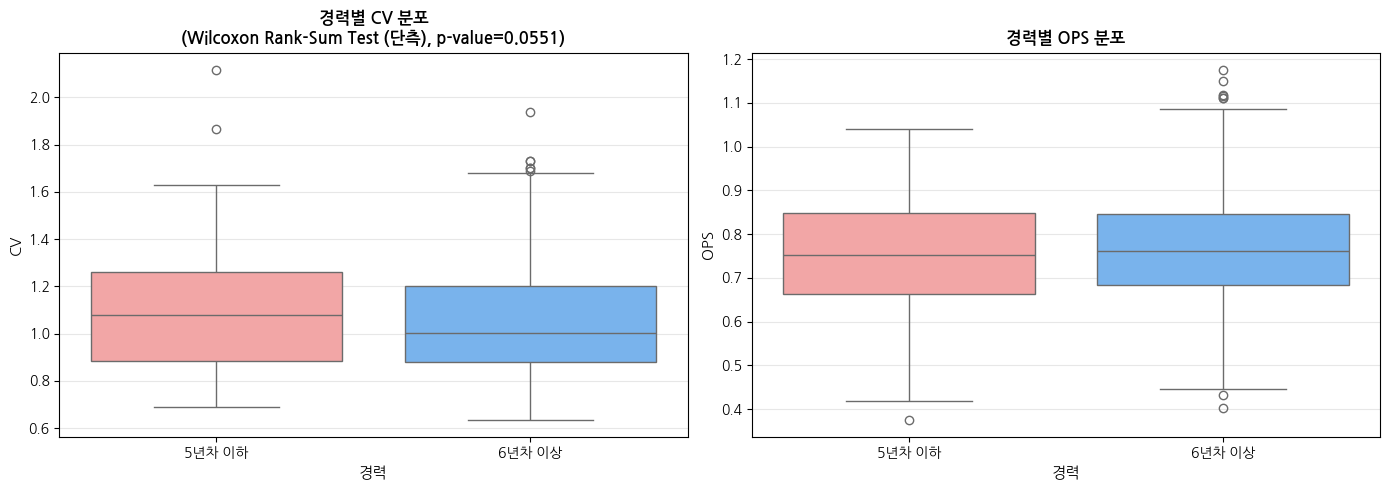

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='career_group', y='CV', ax=axes[0], palette=['#ff9999', '#66b3ff'])
axes[0].set_title(f'경력별 CV 분포\n({test_name}, p-value={p_value:.4f})', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('경력', fontsize=11)
axes[0].set_ylabel('CV', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

sns.boxplot(data=df, x='career_group', y='OPS', ax=axes[1], palette=['#ff9999', '#66b3ff'])
axes[1].set_title('경력별 OPS 분포', fontsize=12, fontweight='bold')
axes[1].set_xlabel('경력', fontsize=11)
axes[1].set_ylabel('OPS', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(data_path + 'h3_career_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.5 종합 결과 요약

In [17]:
print("\n" + "="*70)
print("가설 검정 종합 결과".center(70))
print("="*70)

print("\n[가설 1] 장타형 타자가 안타형 타자보다 타율 변동성(CV)이 크다")
print(f"  - 검정 방법: Wilcoxon Rank-Sum Test (단측)")
print(f"  - 장타형 평균 CV: {power_hitters.mean():.4f}")
print(f"  - 안타형 평균 CV: {contact_hitters.mean():.4f}")
print(f"  - p-value: {p_value:.4f}")
print(f"  - 결론: {'기각 (차이 있음)' if p_value < 0.05 else '유지 (차이 없음)'}")

print("\n[가설 2] 포지션에 따라 타격 일관성에 차이가 있다")
print(f"  - 검정 방법: Kruskal-Wallis Test")
print(f"  - 내야수 평균 CV: {infielder.mean():.4f}")
print(f"  - 외야수 평균 CV: {outfielder.mean():.4f}")
print(f"  - 포수 평균 CV: {catcher.mean():.4f}")
print(f"  - p-value: {p_value:.4f}")
print(f"  - 결론: {'기각 (차이 있음)' if p_value < 0.05 else '유지 (차이 없음)'}")

print("\n[가설 3] 경력이 쌓일수록 성적 안정성이 높아진다")
print(f"  - 검정 방법: Wilcoxon Rank-Sum Test (단측)")
print(f"  - 5년차 이하 평균 CV: {rookie.mean():.4f}")
print(f"  - 6년차 이상 평균 CV: {veteran.mean():.4f}")
print(f"  - p-value: {p_value:.4f}")
print(f"  - 결론: {'기각 (베테랑이 더 안정적)' if p_value < 0.05 else '유지 (차이 없음)'}")

print("\n" + "="*70)


                             가설 검정 종합 결과                              

[가설 1] 장타형 타자가 안타형 타자보다 타율 변동성(CV)이 크다
  - 검정 방법: Wilcoxon Rank-Sum Test (단측)
  - 장타형 평균 CV: 0.9867
  - 안타형 평균 CV: 1.1098
  - p-value: 0.0551
  - 결론: 유지 (차이 없음)

[가설 2] 포지션에 따라 타격 일관성에 차이가 있다
  - 검정 방법: Kruskal-Wallis Test
  - 내야수 평균 CV: 1.0648
  - 외야수 평균 CV: 1.0086
  - 포수 평균 CV: 1.2004
  - p-value: 0.0551
  - 결론: 유지 (차이 없음)

[가설 3] 경력이 쌓일수록 성적 안정성이 높아진다
  - 검정 방법: Wilcoxon Rank-Sum Test (단측)
  - 5년차 이하 평균 CV: 1.1024
  - 6년차 이상 평균 CV: 1.0514
  - p-value: 0.0551
  - 결론: 유지 (차이 없음)

